In [353]:
%run DL_func.ipynb

In [354]:
from sklearn.metrics import r2_score

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [355]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [356]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Y,Env_mean,Env,c
0,0.16,4.03,5.19,0.2,0,red
1,2.12,0.54,3.34,2.0,1,blue
2,0.72,2.78,1.62,0.2,0,red
3,6.40,7.71,15.01,5.0,3,yellow
4,3.39,6.21,10.27,3.0,2,green
...,...,...,...,...,...,...
3995,1.80,3.14,6.35,2.0,1,blue
3996,-0.86,0.59,-1.58,0.2,0,red
3997,2.15,-0.25,2.10,2.0,1,blue
3998,2.08,4.25,7.96,3.0,2,green


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

Text(0, 0.5, 'Z2-axis')

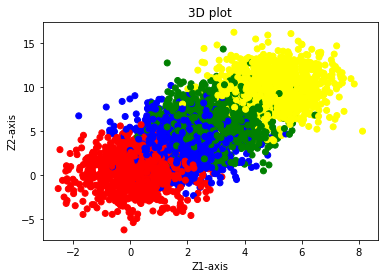

In [357]:
#%matplotlib qt
#plot_latent_3d(df, m)
fig = plt.figure()


# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("3D plot")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [358]:
net=Net1(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [359]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [360]:
class NLPrior(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=output_size*2)
        )
    def forward(self, x):
        return self.function(x).chunk(2, axis = -1)

In [361]:
import pdb
class iCARL(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, y_dim, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
                # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.TNN = nn.Sequential(
            nn.Linear(in_features=input_size_de, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaNN = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaf = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=input_size_de*2*2)
        )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        #ye = torch.cat((y, e), 1)
        #prior_u, prior_sigma = self.func(ye).chunk(2, axis = -1)
        #prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, z
    
    def elbo(self, x, y, e, beta=1):
        # Get encoder and decoder params
        zu, zsigma, de_u, z = self.forward(x, y, e)
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        # Get prior params
        ye = torch.cat((y.detach(),e.detach()),1)
        TNN_params, _ = self.TNN(z_temp).chunk(2, axis = -1)
        lambdaNN_params, _ = self.lambdaNN(ye).chunk(2, axis = -1)
        lambdaf_params, _ = self.lambdaf(ye).chunk(2, axis = -1)
        
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z_temp, z_temp.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)
        pz_ye = nn_ + f_
        dpz_ye = torch.autograd.grad(pz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)
        
        #log_pz_ye = self.normal_dist.log_pdf(z, prior_u, prior_sigma)

        # And compute kl and elbo
        #kl = -log_qz_xye + log_pz_ye

        elbo = log_px_z - log_qz_xye + pz_ye.detach()

        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

    
    

In [362]:
z_dim = 2
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net=iCARL(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [363]:
x,y,e = next(iter(train_loader))
elbo_SM, elbo, SM = net.elbo(x.float(),y.float(),e.float())

In [364]:
elbo

tensor(-1634.8361, grad_fn=<MeanBackward0>)

In [365]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(9.3899)
Epoch 40 of 200
Train loss: tensor(-36.8486)
Epoch 60 of 200
Train loss: tensor(-78.3234)
Epoch 80 of 200
Train loss: tensor(-84.2071)
Epoch 100 of 200
Train loss: tensor(-78.6164)
Epoch 120 of 200
Train loss: tensor(-74.2791)
Epoch 140 of 200
Train loss: tensor(-70.3887)
Epoch 160 of 200
Train loss: tensor(-65.4846)
Epoch 180 of 200
Train loss: tensor(-56.3546)
Epoch 200 of 200
Train loss: tensor(-52.0209)


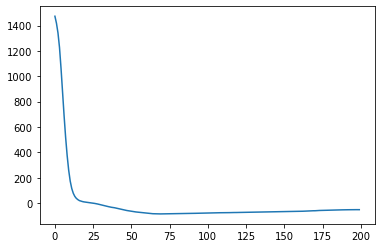

In [366]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [367]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [368]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [369]:
m

0          red
1        green
2       yellow
3          red
4          red
         ...  
1915     green
1916       red
1917       red
1918       red
1919      blue
Name: Env, Length: 1920, dtype: object

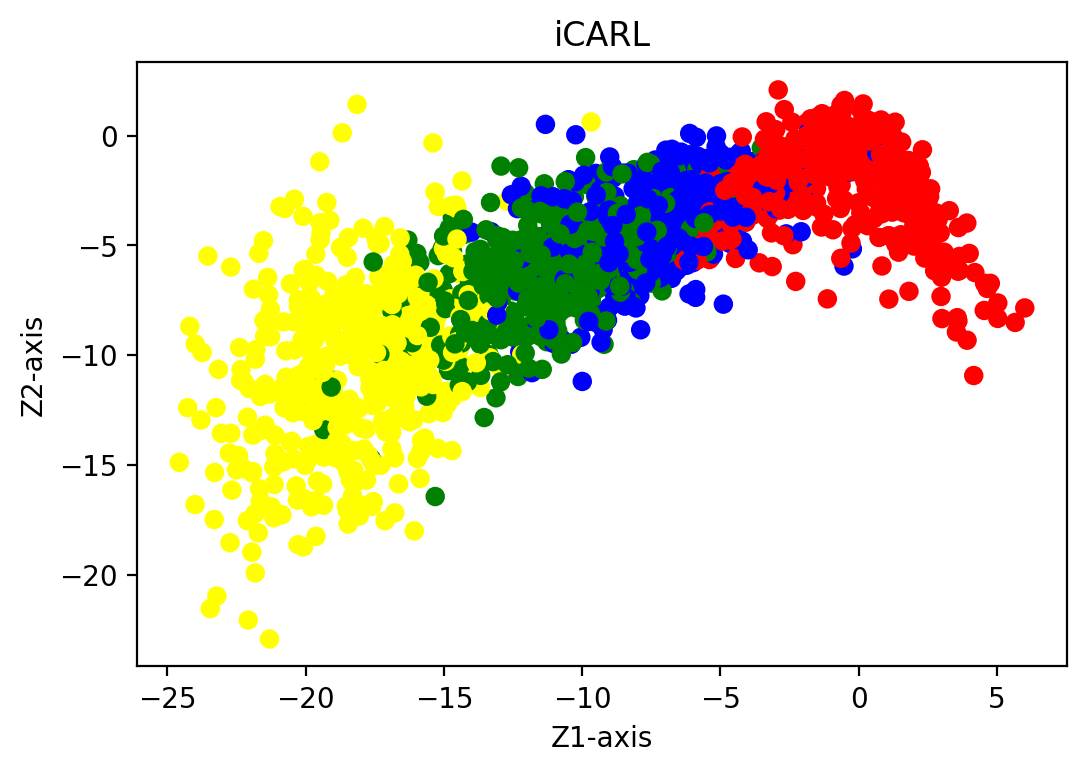

In [376]:
# creating the plot
plt.figure(figsize=(6,4), dpi = 200)
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("iCARL")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')
plt.savefig('Plot_iCARL_2z.jpg')

In [371]:
pdf=df[['Z1', 'Z2']]
pdf.columns = ['pZ1', 'pZ2']
cdf=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values

#corrs=cdf.corr().iloc[:3,3:]
#mcc=corrs.max().mean()
#mcc_abs=np.abs(corrs.max()).mean()
#mcc, mcc_abs
cdf.corr()

,Z1,Z2,pZ1,pZ2
Z1,1.000000,0.751534,-0.924656,-0.767939
Z2,0.751534,1.000000,-0.938601,-0.685229
pZ1,-0.924656,-0.938601,1.000000,0.765596
pZ2,-0.767939,-0.685229,0.765596,1.000000


In [372]:
# MCC value
np.abs(cdf.corr().iloc[:2,2:]).max().mean()

0.8532698456709438

In [373]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    from paper: 
    We also compute the mean correlation coefficient (MCC) used in Khemakhem et al. (2020a), which
    can be obtained by calculating the correlation coefficient between all pairs of true and recovered
    latent factors and then solving a linear sum assignment problem by assigning each recovered latent
    factor to the true latent factor with which it best correlates

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): _description_
    """
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted
    row_ind, col_ind = linear_sum_assignment(reduced_matrix, maximize=True)

    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]
    print(mcc)
    mcc = np.sum(mcc) / (num_predicted)
    return mcc

In [374]:
MCC(cdf.iloc[:,:2].values, pdf.values)

[0.7679390978441951, 0.9386005934976925]


0.8532698456709438

In [375]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['Y']=Y[2000:3920]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
dfc['Z3x_1']=dfc['Z3']*dfc[1]
dfc['Z3x_2']=dfc['Z3']*dfc[2]
dfc['Z3x_3']=dfc['Z3']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

KeyError: 'Z3'

In [ ]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [ ]:
train=df.iloc[:1600,:]
test=df.iloc[:1600,:]

In [ ]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['Y'], test[['Z1', 'Z2', 'Z3']], test['Y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['Y'], test[['Z1', 'Z2']], test['Y'])
y_pred=predict_y(dfc, train[['Z3']], train['Y'], test[['Z3']], test['Y'])

In [ ]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['y'], test[['Z1', 'Z2', 'Z3']], test['y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['y'], test[['Z1', 'Z2']], test['y'])
y_pred=predict_y(dfc, train[['Z3']], train['y'], test[['Z3']], test['y'])

## Case with just 2 latent variables ##

In [ ]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [ ]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

In [ ]:
# for creating a responsive plot
#%matplotlib qt

#plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [ ]:
net=Net(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [ ]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [ ]:
net=UglyiVAE(x.float(), y.float(), e.float(), 15, 2, 2, 10, 5, 2, beta=1)

In [ ]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [ ]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [ ]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [ ]:
#%matplotlib qt
#plot_latent_3d(df, m)
fig = plt.figure()


# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("3D plot")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')

In [ ]:
pdf=df[['Z1', 'Z2']]
pdf.columns = ['pZ1', 'pZ2']
cdf=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values

corrs=cdf.corr().iloc[:2,2:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs

In [ ]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['y']=Y[2000:3920]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

In [ ]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [ ]:
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['y'], test[['Z1', 'Z2']], test['y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])

In [ ]:
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['y'], test[['Z1', 'Z2']], test['y'])

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
MSE(y_pred, test['y'])
r2_score(y_pred, test['y'])

In [ ]:
graphdf=df[['Z1', 'Z2', 'y']]

In [ ]:
graphdf.values

In [ ]:
from causallearn.utils.cit import CIT
kci_obj = CIT(graphdf.values, "kci") 
kci_obj(0,1, {2})
#pE = kci_obj(0, 1, {3})
#pYE = kci_obj(0, 1, {2, 3})

In [ ]:
from causallearn.search.ConstraintBased.PC import pc   
cg = pc(graphdf.values, 0.25)

In [ ]:
# visualization using pydot
cg.draw_pydot_graph(labels = graphdf.columns)

In [ ]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()
# apply graph lasso to data
skeleton = glasso.predict(dfc)
# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

In [ ]:
# Use causal discovery to get causal models
# PC algorithm
model_pc = cdt.causality.graph.PC()
graph_pc = model_pc.predict(dfc, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r')